In [67]:
import numpy as np
import pandas as pd

import os
import glob
import pathlib
import cv2
import PIL

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [68]:
#加载数据
data_dir = r"F:\dataSet\PE\尖山晶科\new_20"
data_dir = data_dir.replace('\\', '/')
Total_ImagePath = data_dir + '/*/*.PNG'
#转换成path路径，方便后续提取图像路径名称
data_dir = pathlib.Path(data_dir)

In [69]:
#使用glob获取所有图像
Total_Images = glob.glob(Total_ImagePath)
print("Total number of images:", len(Total_Images))
#将图像路径转换成Series，方便后续读取
Total_Images = pd.Series(Total_Images)

Total number of images: 415


In [70]:
#使用lambda函数提取图像类别
total_df = pd.DataFrame()
#最后一个是图像名称
#.map是应用当前pd.Series下的所有元素
total_df['FileName'] = Total_Images.map(lambda x: x.split("\\")[-1])
#倒数第二个是类别
total_df['ClassId'] = Total_Images.map(lambda x: x.split("\\")[-2])
#显示前5行
total_df.head()

,FileName,ClassId
0,rotated_90.000000000000.PNG,1
1,rotated_90.0000000000000.PNG,1
2,rotated_90.00000000000000.PNG,1
3,rotated_90.000000000000000.PNG,1
4,rotated_90.0000000000000000.PNG,1


In [71]:
class_id_distribution = total_df['ClassId'].value_counts()
class_id_distribution

11    68
17    66
14    58
16    45
13    37
12    35
9     34
1     30
4     21
15    21
Name: ClassId, dtype: int64

In [72]:
#分析数据
#显示类别分布
fig = go.Figure(go.Bar(
    x = class_id_distribution.values,
    y = class_id_distribution.index,
    orientation = 'h'
))

fig.update_layout(title = "Data Distribution in Bars", xaxis_title = "Count", yaxis_title = "ClassId",
                  font_size = 15, title_x = 0.45)
fig.show()

In [73]:
#使用饼图去显示分布情况
fig = px.pie(class_id_distribution, values='ClassId',names=total_df['ClassId'].unique(), hole=0.425)
fig.update_layout(title = "Data Distribution in Pie Chart", font_size = 15, title_x = 0.45, 
                  annotations=[dict(text='Pistachio',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size = 15, textinfo='percent')

In [74]:
#分割数据集
#使用splitfloder函数分割数据集
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(0.8, 0.1, 0.1))
#splitfolders.fixed(data_dir, output="output", seed=101, fixed=(3, 3), oversample=True)

In [75]:
train_path = "output/train"
val_path = "output/val"
test_path = "output/test"

class_names = os.listdir(train_path)
class_names_val = os.listdir(val_path)
class_names_test = os.listdir(test_path)
class_names
print(len(class_names))

10


In [76]:
train_images = glob.glob(train_path + '/*/*.PNG')
print("train_images:", len(train_images))

val_images = glob.glob(val_path + '/*/*.PNG')
print("val_images:", len(val_images))

test_images = glob.glob(test_path + '/*/*.PNG')
print("test_images:", len(test_images))


train_images: 328
val_images: 37
test_images: 50


In [77]:
#显示数据的分布
random_x = [len(train_images), len(val_images), len(test_images)]
names = ["train_images", "val_images", "test_images"]
fig = px.pie(values=random_x, names=names, hole=0.425)
fig.update_layout(title = "Data Distribution in Pie Chart", font_size = 15, title_x = 0.45, 
                  annotations=[dict(text='Pistachio',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size = 15, textinfo='percent')
fig.show()

In [78]:
train_image_names = pd.Series(train_images)
train_df = pd.DataFrame()
train_df['Filename'] = train_image_names.map(lambda x: x.split("\\")[-1])
train_df['ClassId'] = train_image_names.map(lambda x: x.split("\\")[-2])
train_df.head()

,Filename,ClassId
0,rotated_90.000000000000.PNG,1
1,rotated_90.0000000000000.PNG,1
2,rotated_90.00000000000000.PNG,1
3,rotated_90.000000000000000.PNG,1
4,rotated_90.0000000000000000.PNG,1


In [79]:
#显示训练集的类别分布
fig = go.Figure(go.Bar(
    x = train_df['ClassId'].value_counts().values,
    y = train_df['ClassId'].value_counts().index,
    orientation = 'h'
))
fig.update_layout(title = "Train Data Distribution in Bars", xaxis_title = "Count", yaxis_title = "ClassId")
fig.show()

In [80]:
#显示测试数据集的分布
test_images = pd.Series(test_images)
test_df = pd.DataFrame()
test_df['Filename'] = test_images.map(lambda x: x.split("\\")[-1])
test_df['ClassId'] = test_images.map(lambda x: x.split("\\")[-2])
test_df.head()

,Filename,ClassId
0,rotated_90.000000000000000000.PNG,1
1,rotated_90.000000000000000000000000000000.PNG,1
2,rotated_95.000000000000.PNG,1
3,147.0000000.PNG,11
4,147.00000000000000000000000.PNG,11


In [81]:
fig = go.Figure(go.Bar(
    x = test_df['ClassId'].value_counts().values,
    y = test_df['ClassId'].value_counts().index,
    orientation = 'h'
))
fig.update_layout(title = "Test Data Distribution in Bars")
fig.show()

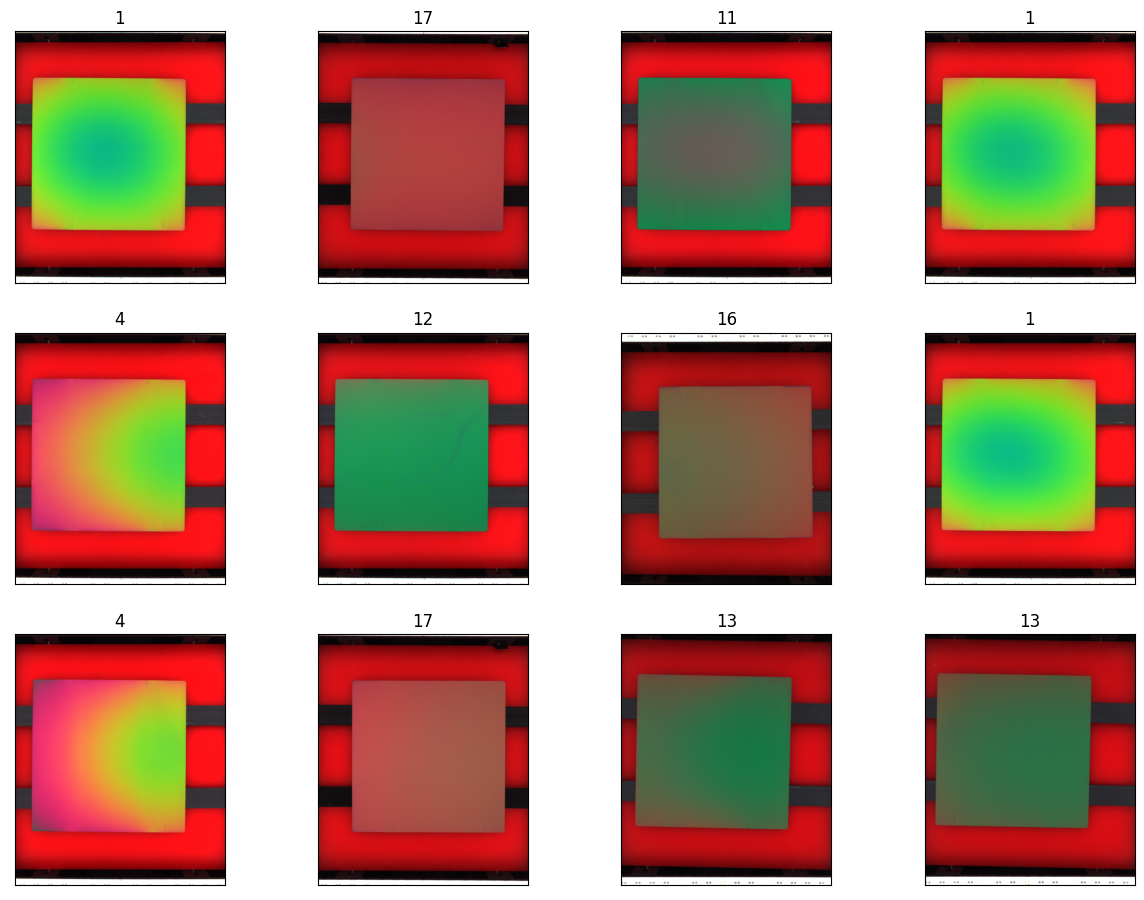

In [82]:
#展示数据
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(15, 15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    label_str = plot_df.loc[i, 'ClassId']
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(train_path, label_str, img_name))
    plt.imshow(img)
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, brightness_range = [0.1, 0.9],
                                   channel_shift_range=0.2)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, shuffle=True, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, shuffle=True, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, shuffle=True, class_mode='categorical')

Found 328 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 37 images belonging to 10 classes.


In [84]:
#加载模型
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2

#model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [85]:
#修改模型的参数
model.trainable = True
for layer in model.layers[:-15]:
    layer.trainable = False

In [86]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

print_layer_trainable()

False:	input_4
False:	Conv1
False:	bn_Conv1
False:	Conv1_relu
False:	expanded_conv_depthwise
False:	expanded_conv_depthwise_BN
False:	expanded_conv_depthwise_relu
False:	expanded_conv_project
False:	expanded_conv_project_BN
False:	block_1_expand
False:	block_1_expand_BN
False:	block_1_expand_relu
False:	block_1_pad
False:	block_1_depthwise
False:	block_1_depthwise_BN
False:	block_1_depthwise_relu
False:	block_1_project
False:	block_1_project_BN
False:	block_2_expand
False:	block_2_expand_BN
False:	block_2_expand_relu
False:	block_2_depthwise
False:	block_2_depthwise_BN
False:	block_2_depthwise_relu
False:	block_2_project
False:	block_2_project_BN
False:	block_2_add
False:	block_3_expand
False:	block_3_expand_BN
False:	block_3_expand_relu
False:	block_3_pad
False:	block_3_depthwise
False:	block_3_depthwise_BN
False:	block_3_depthwise_relu
False:	block_3_project
False:	block_3_project_BN
False:	block_4_expand
False:	block_4_expand_BN
False:	block_4_expand_relu
False:	block_4_depthwise
Fa

In [87]:
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")


In [103]:
from tensorflow.keras.layers import Dropout, Flatten, Dense
x = Flatten()(model.output)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(len(class_names), activation='softmax')(x)

model = keras.models.Model(inputs=model.input, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
print_layer_trainable()

False:	input_4
False:	Conv1
False:	bn_Conv1
False:	Conv1_relu
False:	expanded_conv_depthwise
False:	expanded_conv_depthwise_BN
False:	expanded_conv_depthwise_relu
False:	expanded_conv_project
False:	expanded_conv_project_BN
False:	block_1_expand
False:	block_1_expand_BN
False:	block_1_expand_relu
False:	block_1_pad
False:	block_1_depthwise
False:	block_1_depthwise_BN
False:	block_1_depthwise_relu
False:	block_1_project
False:	block_1_project_BN
False:	block_2_expand
False:	block_2_expand_BN
False:	block_2_expand_relu
False:	block_2_depthwise
False:	block_2_depthwise_BN
False:	block_2_depthwise_relu
False:	block_2_project
False:	block_2_project_BN
False:	block_2_add
False:	block_3_expand
False:	block_3_expand_BN
False:	block_3_expand_relu
False:	block_3_pad
False:	block_3_depthwise
False:	block_3_depthwise_BN
False:	block_3_depthwise_relu
False:	block_3_project
False:	block_3_project_BN
False:	block_4_expand
False:	block_4_expand_BN
False:	block_4_expand_relu
False:	block_4_depthwise
Fa

In [89]:
#可视化模型
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
# Image(filename='convnet.png')

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\visualkeras\layered.py:86: UserWarning:

The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.



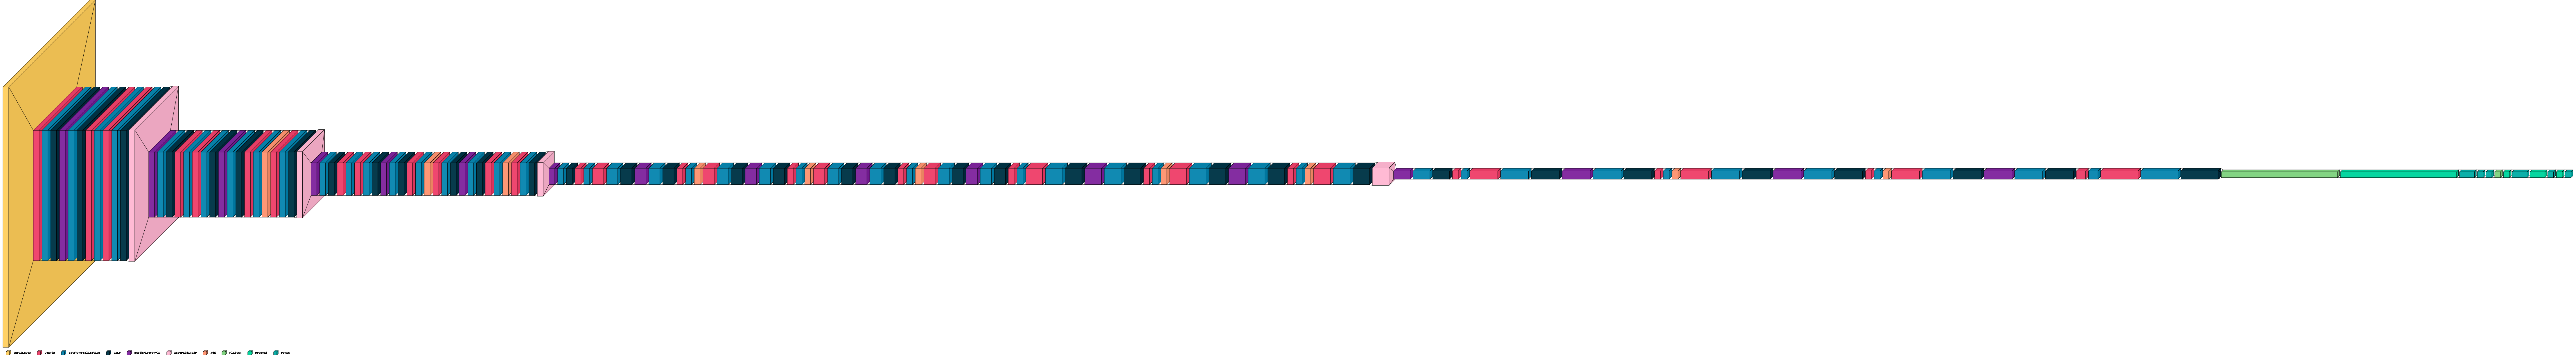

In [104]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

In [105]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, verbose=1)

In [106]:
mc = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [108]:
#训练模型
#H = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[es, mc],workers=4)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model, load_model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.4)(x)

predictions = layers.Dense(len(class_names), activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=int(0.1 * len(test_generator)),
                    verbose=1)

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_7/block1_conv2/Relu (defined at C:\Users\Leaper\AppData\Local\Temp\ipykernel_35164\1860029581.py:29) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_51771]

Function call stack:
train_function


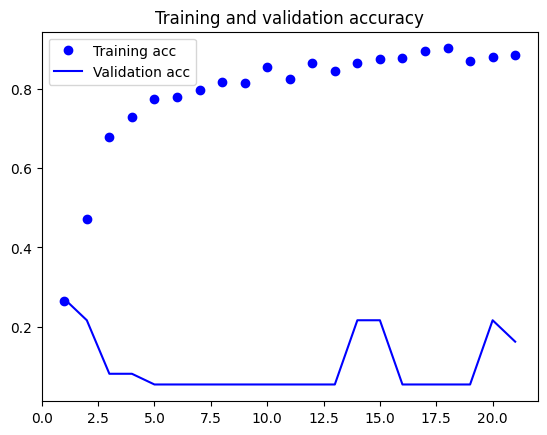

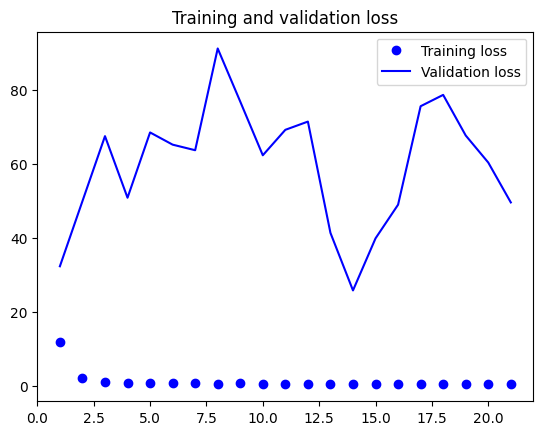

In [94]:
#画出损失曲线
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [95]:
#模型评估
test_loss, test_acc = model.evaluate(test_generator, steps = len(test_generator), verbose = 1)
print('Loss: %.3f'%(test_loss * 100.0))
print('Accuracy: %.3f'%(test_acc * 100.0))

2/2 [==============================] - 4s 2s/step - loss: 52.2048 - accuracy: 0.1600
Loss: 5220.484
Accuracy: 16.000


In [96]:
from sklearn.metrics import classification_report, confusion_matrix

y_val = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         5
           7       0.16      1.00      0.28         8
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4

    accuracy                           0.16        50
   macro avg       0.02      0.10      0.03        50
weighted avg       0.03      0.16      0.04        50



c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [97]:
class_indices = test_generator.class_indices
indices = {v:k for k, v in class_indices.items()}
indices

{0: '1',
 1: '11',
 2: '12',
 3: '13',
 4: '14',
 5: '15',
 6: '16',
 7: '17',
 8: '4',
 9: '9'}

In [98]:
filenames = test_generator.filenames
filenames

['1\\rotated_90.000000000000000000.PNG',
 '1\\rotated_90.000000000000000000000000000000.PNG',
 '1\\rotated_95.000000000000.PNG',
 '11\\147.0000000.PNG',
 '11\\147.00000000000000000000000.PNG',
 '11\\147.PNG',
 '11\\rotated_145.000.PNG',
 '11\\rotated_145.000000000000000.PNG',
 '11\\rotated_147.00000000.PNG',
 '11\\rotated_148.00 (3).PNG',
 '11\\rotated_148.00 (4).PNG',
 '12\\rotated_150.0000.PNG',
 '12\\rotated_150.000000000000000000000.PNG',
 '12\\rotated_150.0000000000000000000000000000000.PNG',
 '12\\rotated_150.00000000000000000000000000000000000000.PNG',
 '13\\rotated_151.000.PNG',
 '13\\rotated_156.00000.PNG',
 '13\\rotated_158.0000000.PNG',
 '13\\rotated_162.000000000000.PNG',
 '13\\rotated_163.00000.PNG',
 '14\\rotated_164.000000000000000.PNG',
 '14\\rotated_165.00000000000000000000000000.PNG',
 '14\\rotated_165.PNG',
 '14\\rotated_167.00000000000000000000000000000000000000000.PNG',
 '14\\rotated_168.000.PNG',
 '14\\rotated_168.00000000000000.PNG',
 '14\\rotated_169.00000000000

In [99]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual'] == val_df['predicted'], 'Same'] = True
val_df.loc[val_df['actual'] != val_df['predicted'], 'Same'] = False
val_df.head()

,filename,actual,predicted,Same
0,1\rotated_90.000000000000000000.PNG,1,17,False
1,1\rotated_90.000000000000000000000000000000.PNG,1,17,False
2,1\rotated_95.000000000000.PNG,1,17,False
3,11\147.0000000.PNG,11,17,False
4,11\147.00000000000000000000000.PNG,11,17,False


In [100]:
val_df = val_df.sample(frac = 1).reset_index(drop=True)


In [101]:
#预测比较
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img_size = 224
def readImage(path):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        image = readImage(f"F:/dataSet/PE/尖山晶科/new/{temp_df.filename[i]}")
        plt.imshow(image)

        plt.title(f'A: {temp_df.actual[i]} P:{temp_df.predicted[i]}')


KeyError: 8

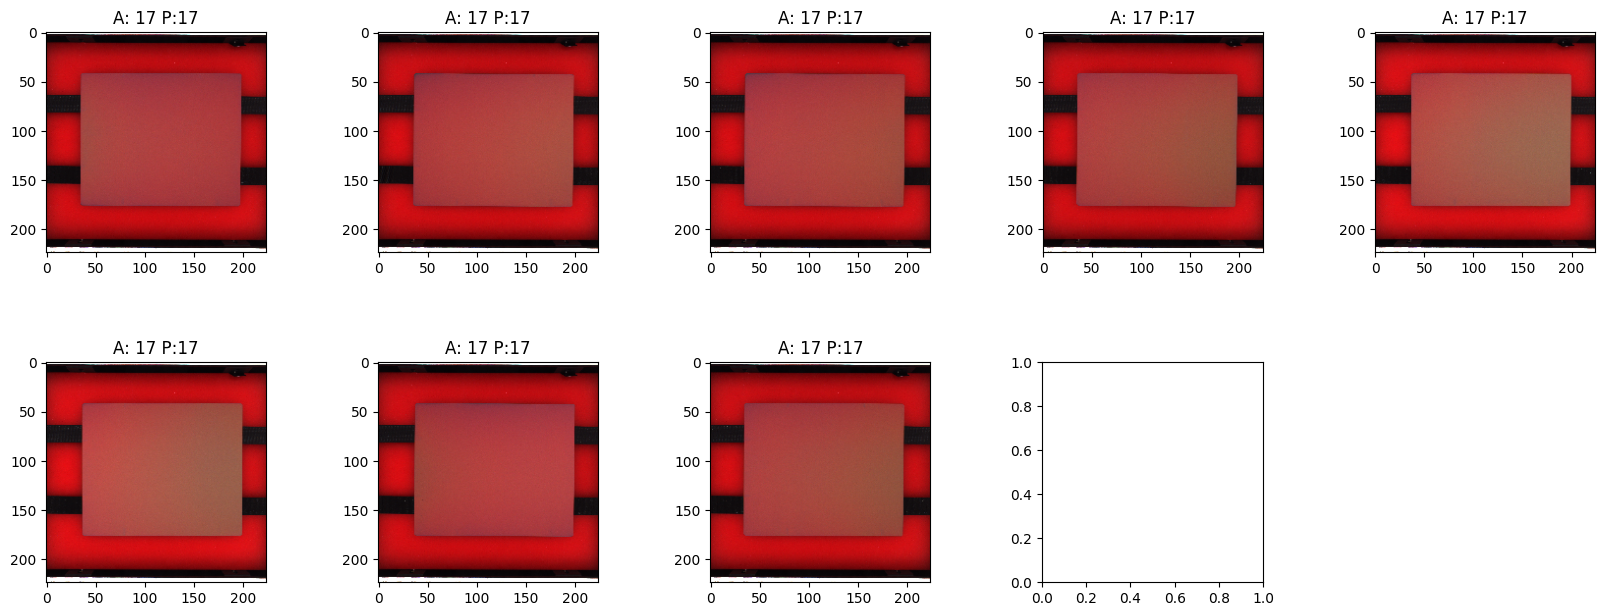

In [102]:
display_images(val_df[val_df['Same']==True])

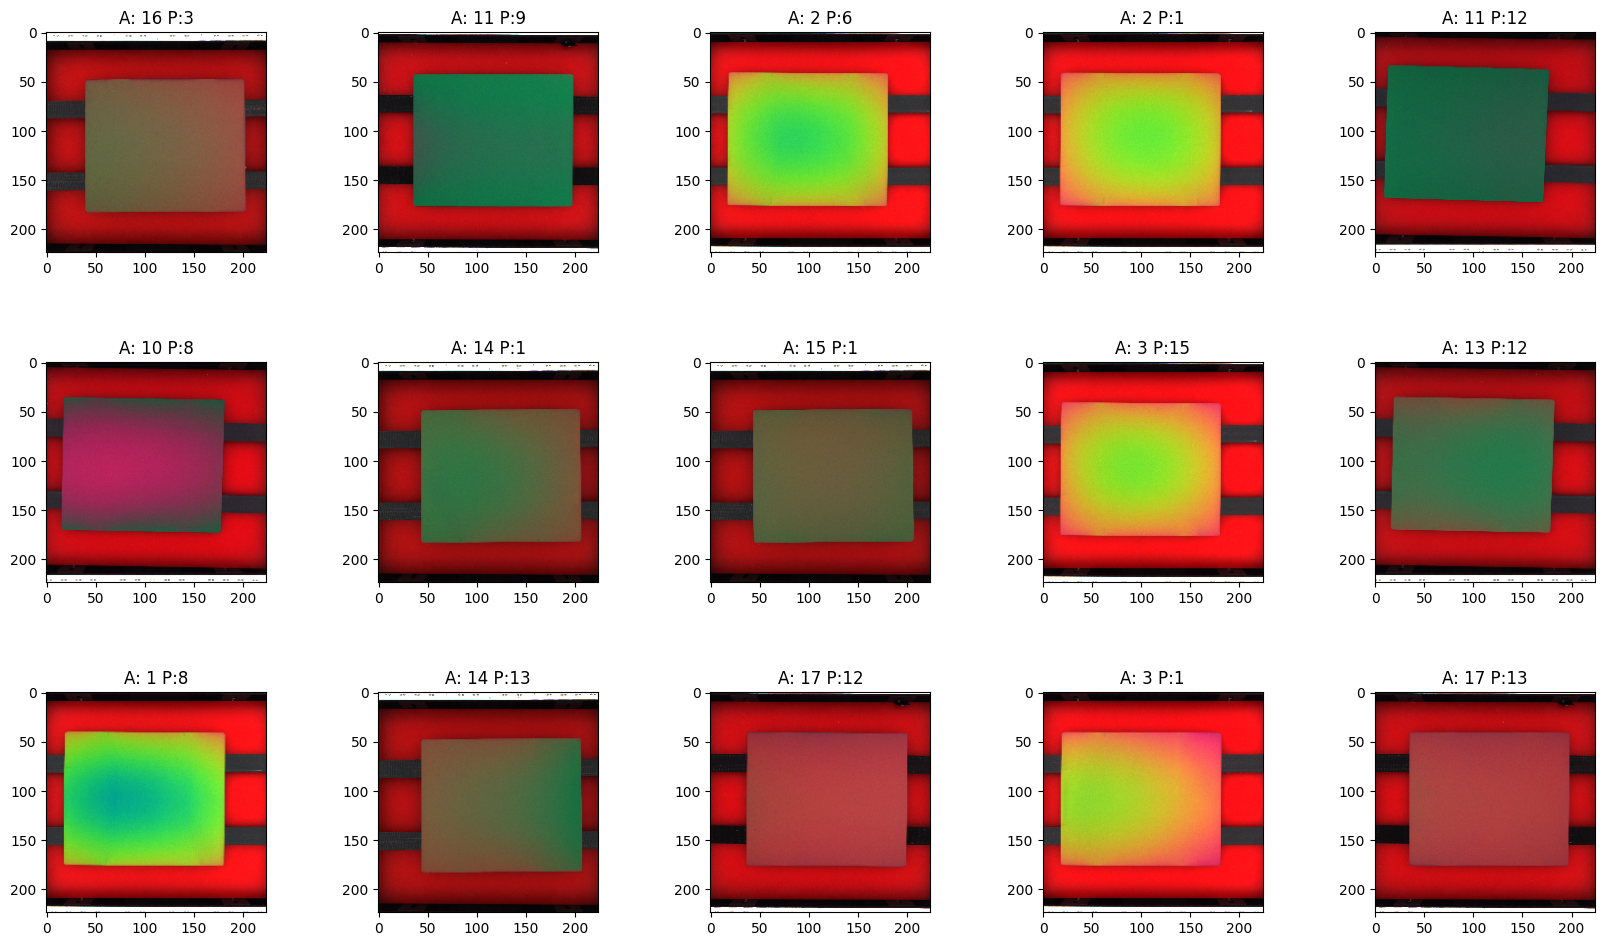

In [ ]:
display_images(val_df[val_df['Same'] == False])

In [ ]:
#混淆矩阵
cm = confusion_matrix(y_val, y_pred)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")

    else:
        print("Confusion matrix, without normalization")
        print(cm)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment = 'center',
        color = "white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[0 1 0 0 0 1 0 0 3 0 1 1 0 0 0 1 2]
 [0 0 1 0 1 0 0 2 0 0 0 0 0 0 0 1 0]
 [0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 2 0 1 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]
 [0 0 0 2 0 0 0 0 1 0 1 1 0 0 0 0 0]
 [0 0 1 1 1 0 0 0 0 0 0 0 2 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0]
 [1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]]


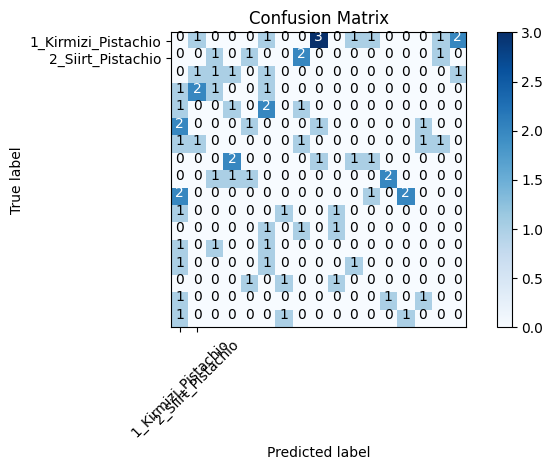

In [ ]:
cm_plot_labels = ['1_Kirmizi_Pistachio', '2_Siirt_Pistachio']

plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')